# Simulating Orbital Mechanics

In [65]:
import numpy as np
import sympy as sp
import sympy.physics.mechanics as spm
import scipy.integrate as spi
import matplotlib.pyplot as plt
sp.init_printing()
spm.init_vprinting()
dispForm = lambda lab, form: display(sp.Eq(sp.Symbol(lab), form))

## 2D Two Body Problem

![Two Body Problem](resources/two-body-orbital-diagram.svg)

System has rotational symmetry. Using polar coordinates $r_1\ \theta_1\ r_2\ \theta_2$ and derivatives $\dot{r}_1\ \dot{\theta}_1\ \dot{r}_2\ \dot{\theta}_2$. We can declare $s$ as the distance between both planets. $s$ is described by the following formula:

$$
s = \sqrt{ r_1^2 + r_2^2 - 2 r_1 r_2 \cos{ \left( \theta_2 - \theta_1 \right) } }
$$

We'll keep $s$ as is in order to make the derivations simpler and more elegant.

In [66]:
G, m1, m2 = sp.symbols('G m_1 m_2')
t = sp.symbols('t')
r1, r2, th1, th2 = spm.dynamicsymbols('r_1 r_2 \\theta_1 \\theta_2')
r1d, r2d, th1d, th2d = tuple( x.diff() for x in (r1, r2, th1, th2) )
s = sp.Function('s')(r1, r2, th1, th2)

Since we're using Lagrangian mechanics, we derive the Lagrangian based on kinetic and potential energy. Potential energy relies only on the $s$ parameter, which we will try to keep as is in the final equations of motion so we won't have to compute them over and over again.

In [67]:
L = (m1 * (r1d**2 + (r1*th1d)**2) + m2 * (r2d**2 + (r2*th2d)**2)) / 2  - G * m1 * m2 / s
dispForm('L', L)

We plug this formula into the Euler-Lagrange equation to get our output solutions for each degree of freedom

$$
\frac{\partial L}{\partial q_i} = \frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q}_i} \right)
$$

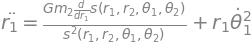

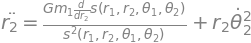

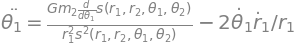

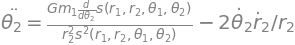

In [68]:
def solve_euler_lagrange(q, qd):
    """
    Return solution to Euler-Lagrange equation 
    for lagrangian wrt coordinate and respective 
    time derivative
    """
    eL = L.diff(q) - L.diff(qd).diff(t)
    return sp.solve(eL, qd.diff())[0]

r1dd = solve_euler_lagrange(r1, r1d)
r2dd = solve_euler_lagrange(r2, r2d)
th1dd = solve_euler_lagrange(th1, th1d)
th2dd = solve_euler_lagrange(th2, th2d)
dispForm('\\ddot{r_1}',       r1dd)
dispForm('\\ddot{r_2}',       r2dd)
dispForm('\\ddot{\\theta_1}', th1dd)
dispForm('\\ddot{\\theta_2}', th2dd)

We'll take a detour to solve for those derivatives of $s$. Using the chain rule, we can unravel this derivative piece by piece, keeping the $s$ term in wherever we can. We'll start with the square root term

$$
\begin{align}
\frac{\partial s}{\partial q} &= \frac{\partial}{\partial q} \sqrt{ r_1^2 + r_2^2 - 2 r_1 r_2 \cos{ \left( \theta_2 - \theta_1 \right) } } \\
&= \frac{\frac{\partial}{\partial q} \left( r_1^2 + r_2^2 - 2 r_1 r_2 \cos{ \left( \theta_2 - \theta_1 \right) } \right)}{2 \sqrt{ r_1^2 + r_2^2 - 2 r_1 r_2 \cos{ \left( \theta_2 - \theta_1 \right) } } } \\
&= \frac{ \frac{\partial}{\partial q} \left( r_1^2 + r_2^2 - 2 r_1 r_2 \cos{ \left( \theta_2 - \theta_1 \right) } \right) }{2s}
\end{align}
$$

From this, we can eliminate the square root term from the derivative, and, in fact, replace it with our $s$ term. The rest of the derivative depends on what's inside the square root. The derivatives for each of the coordinates are as follows.

$$
\begin{align}
\frac{\partial s}{\partial r_1} &= \frac{r_1 - r_2\cos{\left( \theta_2 - \theta_1 \right)}}{s} & \frac{\partial s}{\partial \theta_1} &= - \frac{r_1 r_2 \sin{\left( \theta_2 - \theta_1 \right)}}{s} \\
\frac{\partial s}{\partial r_2} &= \frac{r_2 - r_1\cos{\left( \theta_2 - \theta_1 \right)}}{s} & \frac{\partial s}{\partial \theta_2} &= \frac{r_1 r_2 \sin{\left( \theta_2 - \theta_1 \right)}}{s} \\
\end{align}
$$

We can sub each of these into our equations above

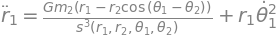

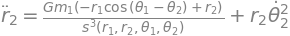

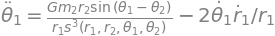

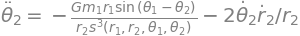

In [69]:
r1dd  = r1dd.subs(   s.diff(r1),  (r1 - r2 * sp.cos(th2 - th1)) / s )
r2dd  = r2dd.subs(   s.diff(r2),  (r2 - r1 * sp.cos(th2 - th1)) / s )
th1dd = th1dd.subs( s.diff(th1), - r1 * r2 * sp.sin(th2 - th1)  / s )
th2dd = th2dd.subs( s.diff(th2),   r1 * r2 * sp.sin(th2 - th1)  / s )
dispForm('\\ddot{r}_1', r1dd)
dispForm('\\ddot{r}_2', r2dd)
dispForm('\\ddot{\\theta}_1', th1dd)
dispForm('\\ddot{\\theta}_2', th2dd)

Finally, sub $s$ with our formula for $s$ above.

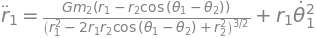

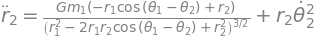

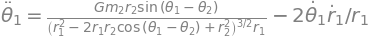

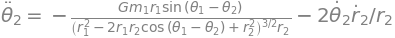

In [70]:
sForm = sp.sqrt(r1**2 + r2**2 - 2*r1*r2*sp.cos(th2 - th1))

r1dd  = r1dd.subs(  s, sForm )
r2dd  = r2dd.subs(  s, sForm )
th1dd = th1dd.subs( s, sForm )
th2dd = th2dd.subs( s, sForm )

dispForm('\\ddot{r}_1', r1dd)
dispForm('\\ddot{r}_2', r2dd)
dispForm('\\ddot{\\theta}_1', th1dd)
dispForm('\\ddot{\\theta}_2', th2dd)

Create a vector which returns input state and updated state

In [71]:
S = sp.Array([ r1, r2, th1, th2, r1d, r2d, th1d, th2d ])
Sd = sp.Array([ r1d, r2d, th1d, th2d, r1dd, r2dd, th1dd, th2dd ])
print('Input State:')
display(S)
print('State Update:')
display(Sd)

Input State:


[r₁  r₂  \theta₁  \theta₂  r₁̇  r₂̇  \thėta₁  \thėta₂]

State Update:


⎡                               G⋅m₂⋅(r₁ - r₂⋅cos(\theta₁ - \theta₂))         
⎢r₁̇  r₂̇  \thėta₁  \thėta₂  ───────────────────────────────────────────────
⎢                                                                      3/2    
⎢                          ⎛  2                                      2⎞       
⎣                          ⎝r₁  - 2⋅r₁⋅r₂⋅cos(\theta₁ - \theta₂) + r₂ ⎠       

         2       G⋅m₁⋅(-r₁⋅cos(\theta₁ - \theta₂) + r₂)                 2     
 + r₁⋅\thėta₁   ─────────────────────────────────────────────── + r₂⋅\thėta₂
                                                        3/2                   
            ⎛  2                                      2⎞                   ⎛  
            ⎝r₁  - 2⋅r₁⋅r₂⋅cos(\theta₁ - \theta₂) + r₂ ⎠                   ⎝r₁

       G⋅m₂⋅r₂⋅sin(\theta₁ - \theta₂)             2⋅\thėta₁⋅r₁̇              
   ────────────────────────────────────────────────── - ────────────  - ──────
                                         3/2      